In [14]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tqdm import tqdm
from gensim.models import Word2Vec as wv

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## This classifier is meant to take in:

- pre-trained embeddings (w2v, but want to try syn and ant embeddings)
- synonymy and antonymy scores


In [2]:
word_pairs_df = pd.read_excel('/Users/wesleytatum/Desktop/post_doc/BETO/BETO2020/Ant_Syn_Scraping/data/new_syn_ant_list.xlsx')
word_pairs_df = word_pairs_df.drop('Unnamed: 0', axis = 1)
print(word_pairs_df['label'].value_counts())
word_pairs_df

1    6534
0    4696
2    3002
Name: label, dtype: int64


,word 1,word 2,label
0,infinite,bounded,2
1,infinite,brief,2
2,infinite,calculable,0
3,infinite,ceasing,2
4,infinite,ending,2
...,...,...,...
14227,charm,fascinate,1
14228,charm,magical spell,1
14229,charm,appealingness,1
14230,charm,enchant,1


In [3]:
#Vocabulary from Carbon corpus and Word2Vec model trained on all abstracts
#Opening contents of Word2Vec model1

w2v_model_path = '/Users/wesleytatum/Desktop/post_doc/data/w2v_models/200D_all_abstracts_model/full_corpus_w2v_mc5_s200_wdw10.model'
model1 = wv.load(w2v_model_path)
vocabulary1 = list(model1.wv.vocab)
print(f'w2v vocab length: {len(vocabulary1)}')

w2v_data_df = word_pairs_df.copy()

#finding which words are in the pd but not in vocabulary1
list1 = list(word_pairs_df['word 1'])
list2 = list(word_pairs_df['word 2'])
missing = list((set(list1).difference(vocabulary1))) + list((set(list2).difference(vocabulary1)))
print(f'number of word pair words: {len(list(set(list1+list2)))}')
print(f'number of missing words: {len(missing)}')

#keeping only the rows in the pd that have words in vocabulary1
w2v_data_df = w2v_data_df[~w2v_data_df['word 1'].isin(missing)]
w2v_data_df = w2v_data_df[~w2v_data_df['word 2'].isin(missing)]

#reseting indeces after mask
w2v_data_df.reset_index(inplace = True)

#creating list of individual words that are both in vocabulary1 and excel sheet 
#dict.fromkeys() ensuring there are no duplicates
common = list(set(list1)&set(vocabulary1))+list(set(list2)&set(vocabulary1))
common = list(dict.fromkeys(common))
common = sorted(common)
print(f'length of common vocab: {len(common)}')

#save vocab list and call it in the Pre_Trained_Embeddings
common_df = pd.DataFrame(common)
common_df.to_csv('./data/words_list.csv', index=False)

w2v vocab length: 358151
number of word pair words: 9043
number of missing words: 2322
length of common vocab: 6733


In [4]:
#for word pairs in our proposed training set, check if both words are in
#the common vocabulary list and then create a new dataframe with their indices

w2v_indx_df = pd.DataFrame(columns = ['word 1', 'word 2', 'label'])

pbar = tqdm(total = len(w2v_data_df), position = 0)

for i in range(len(w2v_data_df)):
    
    word1 = w2v_data_df['word 1'].iloc[i]
    word2 = w2v_data_df['word 2'].iloc[i]
    label = w2v_data_df['label'].iloc[i]
    
    if word1 in common:
        if word2 in common:
            index1 = common.index(word1)
            index2 = common.index(word2)
            w2v_indx_df.loc[i] = pd.Series({'word 1':index1, 'word 2':index2, 'label':label})
        else:
            pass
    else:
        pass
    pbar.update()
    
print(w2v_indx_df.label.value_counts())
w2v_indx_df

100%|█████████▉| 10904/10916 [00:27<00:00, 369.62it/s]

1    4668
0    4001
2    2247
Name: label, dtype: int64


,word 1,word 2,label
0,3140,663,2
1,3140,696,2
2,3140,763,0
3,3140,842,2
4,3140,2071,2
...,...,...,...
10911,3701,356,1
10912,3701,3700,1
10913,3701,3258,1
10914,891,2362,1


100%|██████████| 10916/10916 [00:40<00:00, 369.62it/s]

In [5]:
X = w2v_indx_df[['word 1', 'word 2']]
Y = w2v_indx_df['label']

xtr, xts, ytr, yts = train_test_split(X, Y, test_size = 0.2, shuffle = True)

dtrain = xgb.DMatrix(xtr.values.astype(int), label = ytr.values.astype(int))
dtest = xgb.DMatrix(xts.values.astype(int), label = yts.values.astype(int))

In [6]:
params = {
    'booster' : 'gbtree',
    'verbosity' : 2,
    'eta' : 0.3,
    'gamma' : 0,
    'max_depth' : 6,
    'objective' : 'multi:softmax',
    'num_class' : 3,
}

watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 5

In [7]:
bst = xgb.train(params, dtrain, num_round, watchlist)

[12:55:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=6
[12:55:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=6
[12:55:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-merror:0.49634	train-merror:0.46427
[12:55:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=6
[12:55:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[12:55:29] INFO: /Users/travis/build/dmlc/xgboost/src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-merror:0.47848	train-merror:0.44423
[12:55:29] INFO: /Users/travis/build/dmlc/xgboost/

In [19]:
preds = bst.predict(dtest)
preds

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [9]:
cor_syn = 0
wrng_syn = 0
cor_ant = 0
wrng_ant = 0
cor_irrel = 0
wrng_irrel = 0

for pred, label in zip(preds, yts.values.astype(float)):
    
    if label == 0: #irrels
        if pred == 0:
            cor_irrel += 1
        else:
            wrng_irrel += 1
        
    if label == 1: #syns
        if pred == 1:
            cor_syn += 1
        else:
            wrng_syn += 1
        
    if label == 2: #ants
        if pred == 2:
            cor_ant += 1
        else:
            wrng_ant += 1
            
print(f'irrelevant pairs - {cor_irrel} right, {wrng_irrel} wrong')
print(f'synonymous pairs - {cor_syn} right, {wrng_syn} wrong')
print(f'antonymous pairs - {cor_ant} right, {wrng_ant} wrong')

irrelevant pairs - 353 right, 478 wrong
synonymous pairs - 743 right, 164 wrong
antonymous pairs - 107 right, 339 wrong


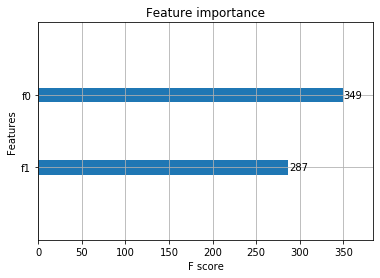

In [10]:
xgb.plot_importance(bst)

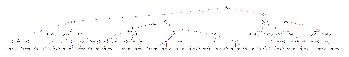

In [15]:
xgb.plot_tree(bst)

In [18]:
d1 = {'a':[1, 2, 3], 'b':[1, 2, 3]}
w1 = [4, 5, 6]
w2 = [4, 5, 6]

tmp1 = d1['a']
tmp2 = d1['b']

d1['a'] = tmp1+w1
d1['b'] = tmp2+w2

d1

{'a': [1, 2, 3, 4, 5, 6], 'b': [1, 2, 3, 4, 5, 6]}